In [1]:
from __future__ import annotations

from vtkbone import vtkboneAIMReader

from bonelab.util.aim_calibration_header import get_aim_density_equation
from bonelab.util.vtk_util import vtkImageData_to_numpy
import numpy as np
from enum import Enum

import SimpleITK as sitk
import pyvista as pv

from matplotlib import pyplot as plt

import os

Utility functions

In [2]:
def align_aims(data: List[Tuple[np.ndarray, List[int]]]) -> List[np.ndarray]:
    min_position = np.asarray([p for _, p in data]).min(axis=0)
    pad_lower = [p - min_position for _, p in data]
    max_shape = np.asarray([(aim.shape + pl) for (aim, _), pl in zip(data, pad_lower)]).max(axis=0)
    pad_upper = [(max_shape - (aim.shape + pl)) for (aim, _), pl in zip(data, pad_lower)]
    return [
        np.pad(aim, tuple([(l, u) for l, u in zip(pl, pu)]), "constant")
        for (aim, _), pl, pu in zip(data, pad_lower, pad_upper)
    ]


def read_image_to_numpy(reader: vtkboneAIMReader, filename: str, density: bool) -> Tuple[np.ndarray, list]:
    reader.SetFileName(filename)
    reader.Update()
    data = vtkImageData_to_numpy(reader.GetOutput())
    if density:
        # convert data to densities
        m, b = get_aim_density_equation(reader.GetProcessingLog())
        data = m * data + b
    return data, reader.GetPosition()


Plotting functions

In [3]:
def get_bean_and_overlay_data(images, site_codes, pad_amount):
    
    data = {}
    
    compartment = np.zeros_like(images[2], dtype=bool)

    for code in site_codes:
        compartment = compartment | (images[1]==code) | (images[2]==code)

    x, y, z = np.where(compartment)
    sh = images[2].shape

    st = (
        min(x) + (max(x) - min(x))//2,
        slice(max(min(y) - pad_amount, 0), min(max(y) + pad_amount, sh[0])),
        slice(max(min(z) - pad_amount, 0), min(max(z) + pad_amount, sh[0]))
    )

    img = np.rot90(images[0][st])
    pred_masks = np.rot90(images[1][st])
    ref_masks = np.rot90(images[2][st])

    st = (
        slice(max(min(x) - pad_amount, 0), min(max(x) + pad_amount, sh[0])),
        slice(max(min(y) - pad_amount, 0), min(max(y) + pad_amount, sh[0])),
        slice(None)
    )

    pred_mip = np.rot90(np.max(images[1][st]>0, axis=2))
    ref_mip = np.rot90(np.max(images[2][st]>0, axis=2))

    tp = pred_mip & ref_mip
    fp = pred_mip & ~ref_mip
    fn = ~pred_mip & ref_mip

    data["x"] = (max(x) - min(x))//2
    data["bean"] = {}
    data["bean"]["tp"] = tp
    data["bean"]["fp"] = fp
    data["bean"]["fn"] = fn
    
    data["img"] = img
    
    data["rois - pred"] = {}
    data["rois - ref"] = {}
    data["rois - errors"] = {}


    for roi_code in site_codes:
        data["rois - pred"][roi_code] = (pred_masks == roi_code).astype(float)
        data["rois - ref"][roi_code] = (ref_masks == roi_code).astype(float)
        data["rois - errors"][roi_code] = (
            data["rois - pred"][roi_code] != data["rois - ref"][roi_code]
        ).astype(float)
        
    return data


def create_bean_and_overlay_plots(data, axs, mask_opacity, bean_cmaps, roi_cmaps):
    
    # BEAN PLOT
    
    for k,v  in data["bean"].items():
        axs[0].imshow(v, cmap=bean_cmaps[k], alpha=mask_opacity*v.astype(float))
    
    axs[0].axvline(x=data["x"], linewidth=2, color="k")
    axs[0].axis(False)

    # ROI PLOTS
        
    axs[1].imshow(data["img"], cmap="gist_gray")

    for k, v in data["rois - pred"].items():
        axs[1].imshow(v, cmap=roi_cmaps[k], alpha=mask_opacity*v, vmin=0, vmax=1)

    axs[1].axis(False)

    axs[2].imshow(data["img"], cmap="gist_gray")

    for k, v in data["rois - ref"].items():
        axs[2].imshow(v, cmap=roi_cmaps[k], alpha=mask_opacity*v, vmin=0, vmax=1)

    axs[2].axis(False)

    axs[3].imshow(data["img"], cmap="gist_gray")
    
    for v in data["rois - errors"].values():
        axs[3].imshow(v, cmap="Reds", alpha=mask_opacity*v, vmin=0, vmax=1)

    axs[3].axis(False)

Define file locations

In [4]:
sample_visualizations_dir = os.path.join(
    "/", "Users", "nathanneeteson", "Documents", "Data",
    "Images", "AutoKneeAnalysis", "sample_visualizations"
)

aims_subdir = "aims"
pred_subdir = "pred_aims"
ref_subdir = "ref_aims"

Define the image names

In [5]:
image_names = {
    "femur": {
        "over": "PREOA_019_L_XCT_F",
        "median": "PREOA_012_L_XCT_F",
        "under": "PREOA_028_L_XCT_F",
    },
    "tibia": {
        "over": "PREOA_012_L_XCT_T",
        "median": "CONMD15L_T",
        "under": "PREOA_028_L_XCT_T"
    }
}

errors = {
    "femur": {
        "over": {
            "error": 0.286373,
            "compartment": "medial"
        },
        "median": {
            "error": 0.161743,
            "compartment": "medial"
        },
        "under": {
            "error": -0.494215,
            "compartment": "medial"
        }
    },
    "tibia": {
        "over": {
            "error": 0.224373,
            "compartment": "lateral"
        },
        "median": {
            "error": 0.11495,
            "compartment": "lateral"
        },
        "under": {
            "error": -1.105833,
            "compartment": "medial"
        }
    }
}

site_codes = {
    "femur": {
        "lateral": [10,11,12,16],
        "medial": [13,14,15,17]
    },
    "tibia": {
        "lateral": [30,31,32,36],
        "medial": [33,34,35,37]
    }
}

Load the images and ROI masks and align everything.

In [10]:
debug = False

reader = vtkboneAIMReader()
reader.DataOnCellsOff()

images = {}
images["femur"] = {}
images["tibia"] = {}

for bone in image_names.keys():
    for error_direction in image_names[bone].keys():
        
        print(bone, error_direction)
        
        img, img_pos = read_image_to_numpy(
            reader,
            os.path.join(
                sample_visualizations_dir,
                aims_subdir,
                f"{image_names[bone][error_direction]}.AIM"
            ),
            True
        )
        
        pred_rois, pred_rois_pos = read_image_to_numpy(
            reader,
            os.path.join(
                sample_visualizations_dir,
                pred_subdir,
                f"{image_names[bone][error_direction]}_ROI_ALL_MASK.AIM"
            ),
            False
        )
        
        ref_rois, ref_rois_pos = read_image_to_numpy(
            reader,
            os.path.join(
                sample_visualizations_dir,
                ref_subdir,
                f"{image_names[bone][error_direction]}_ROI_ALL_MASK.AIM"
            ),
            False
        )
        
        images[bone][error_direction] = align_aims([
            (img, img_pos),
            (pred_rois, pred_rois_pos),
            (ref_rois, ref_rois_pos)
        ])
        
        if debug: break
    if debug: break

femur over
femur median
femur under
tibia over
tibia median
tibia under


In [11]:
pad_amount = 30

plot_data = {}

plot_data["femur"] = {}
plot_data["tibia"] = {}

plot_data["femur"]["over"] = get_bean_and_overlay_data(
    images["femur"]["over"],
    site_codes["femur"]["medial"],
    pad_amount
)

plot_data["femur"]["median"] = get_bean_and_overlay_data(
    images["femur"]["median"],
    site_codes["femur"]["medial"],
    pad_amount
)

plot_data["femur"]["under"] = get_bean_and_overlay_data(
    images["femur"]["under"],
    site_codes["femur"]["medial"],
    pad_amount
)

plot_data["tibia"]["over"] = get_bean_and_overlay_data(
    images["tibia"]["over"],
    site_codes["tibia"]["lateral"],
    pad_amount
)

plot_data["tibia"]["median"] = get_bean_and_overlay_data(
    images["tibia"]["median"],
    site_codes["tibia"]["lateral"],
    pad_amount
)

plot_data["tibia"]["under"] = get_bean_and_overlay_data(
    images["tibia"]["under"],
    site_codes["tibia"]["medial"],
    pad_amount
)


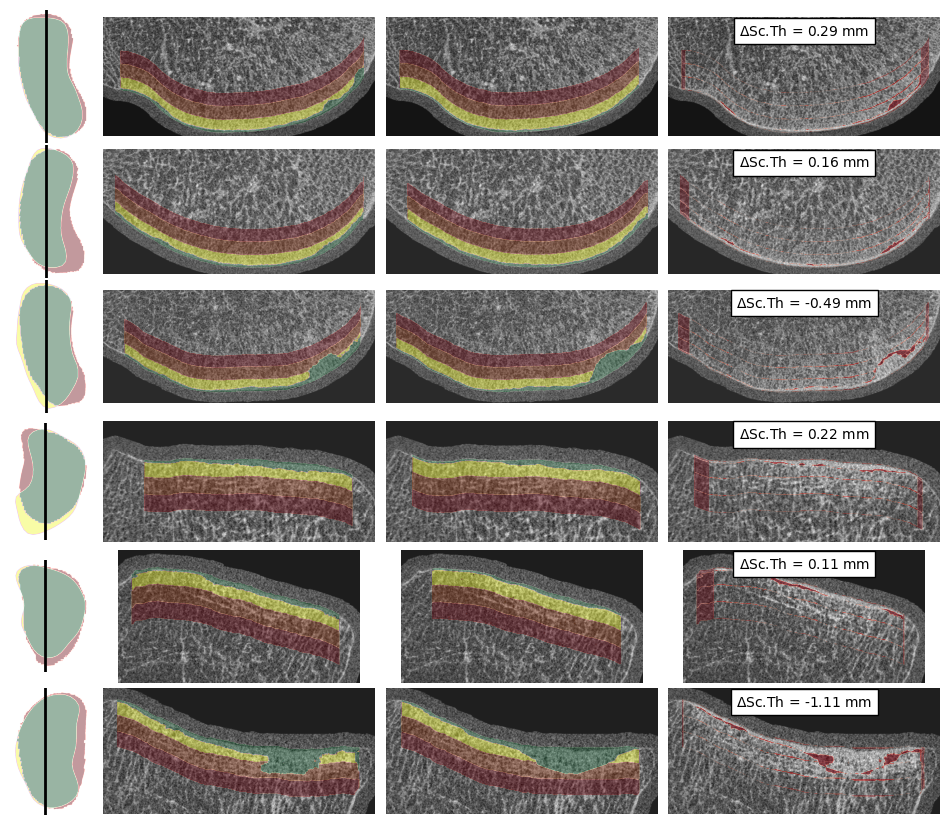

In [12]:
mask_opacity = 0.4

text_h_offset = 0.50
text_v_offset = 0.95

bean_cmaps = {
    "tp": "Greens",
    "fp": "Reds",
    "fn": "plasma"
}

roi_cmaps = {
    10: "plasma",
    11: "Oranges",
    12: "Reds",
    13: "plasma",
    14: "Oranges",
    15: "Reds",
    16: "Greens",
    17: "Greens",
    30: "plasma",
    31: "Oranges",
    32: "Reds",
    33: "plasma",
    34: "Oranges",
    35: "Reds",
    36: "Greens",
    37: "Greens"
}

text_bbox = {
    "edgecolor": "k",
    "facecolor": "w"
}

fig, axs = plt.subplots(
    6, 4, 
    figsize=(12, 10.5), 
    gridspec_kw = {'wspace':0.05, 'hspace':0.01, 'width_ratios': [0.3, 1, 1, 1]}
)

create_bean_and_overlay_plots(plot_data["femur"]["over"], axs[0], mask_opacity, bean_cmaps, roi_cmaps)
create_bean_and_overlay_plots(plot_data["femur"]["median"], axs[1], mask_opacity, bean_cmaps, roi_cmaps)
create_bean_and_overlay_plots(plot_data["femur"]["under"], axs[2], mask_opacity, bean_cmaps, roi_cmaps)
create_bean_and_overlay_plots(plot_data["tibia"]["over"], axs[3], mask_opacity, bean_cmaps, roi_cmaps)
create_bean_and_overlay_plots(plot_data["tibia"]["median"], axs[4], mask_opacity, bean_cmaps, roi_cmaps)
create_bean_and_overlay_plots(plot_data["tibia"]["under"], axs[5], mask_opacity, bean_cmaps, roi_cmaps)


axs[0][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['femur']['over']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[0][3].transAxes,
    bbox=text_bbox
)

axs[1][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['femur']['median']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[1][3].transAxes,
    bbox=text_bbox
)

axs[2][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['femur']['under']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[2][3].transAxes,
    bbox=text_bbox
)

axs[3][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['tibia']['over']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[3][3].transAxes,
    bbox=text_bbox
)

axs[4][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['tibia']['median']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[4][3].transAxes,
    bbox=text_bbox
)

axs[5][3].text(
    text_h_offset, text_v_offset,
    f"$\Delta$Sc.Th = {errors['tibia']['under']['error']:0.2f} mm",
    horizontalalignment='center',
    verticalalignment='top',
    transform=axs[5][3].transAxes,
    bbox=text_bbox
)

plt.savefig("sample_viz.png", dpi=300)

plt.show()